# Value iteration

As a part of our quest to better understand reinforcement learning, we experiment with basic dynamic programming algorithms.

A [key textbook by Sutton and Barto](http://incompleteideas.net/book/RLbook2020.pdf) defines dynamic programming as referring to "_a collection of algorithms that can be used to compute optimal policies given a perfect model of the environment as a Markov decision process (MDP)._"

_Value Iteration_ is one such algorithms and this notebook implements the algorithm on a simple _grid world_ or _maze_ as an _environment_. 

So to start, we need to model the maze environment as a Markov decision process. We first introduce the maze as a Markov Decision Process, as is necessary for applying a dynamic programing algorithm. 

We also briefly cover the underlying theory and introduce the necessary concepts, such as "optimal policies" referred to in the definition quoted above.

Towards the end of the notebook, we outline an implementation of the algorithm in Python and provide execution examples by beginning with the 'canonical maze', a common example used for instance in several university courses. We also illustrate a couple of slightly more complex mazes as additional examples.

Implementation of the maze is reused from [another notebook](./maze_basis.ipynb).

Another fundamental dynamic programming algorithm, _Policy Iteration_, is covered in the [following experiment](./maze_policy_iteration.ipynb).

In [1]:
import math
import numpy as np

from IPython.core.display import SVG

from ipynb.fs.defs.maze_basis import (
    Maze, Movement,
    plot_maze, plot_policy_actions, plot_state_rewards, plot_state_values
)

## Maze as a Markov Decision Process

A maze or a grid-world is an environment consisting of grid-like states. We use the [maze implementation](./maze_basis.ipynb) to plot an illustrative image, showing the canonical maze below. 

The problem represented by the maze has different interpretations in academia: It could be taken as a model for parking a car in a slippery garage, or modeling movement of a robot in a room, or even a robot chasing diamonds while avoiding a scary pit of fire.  

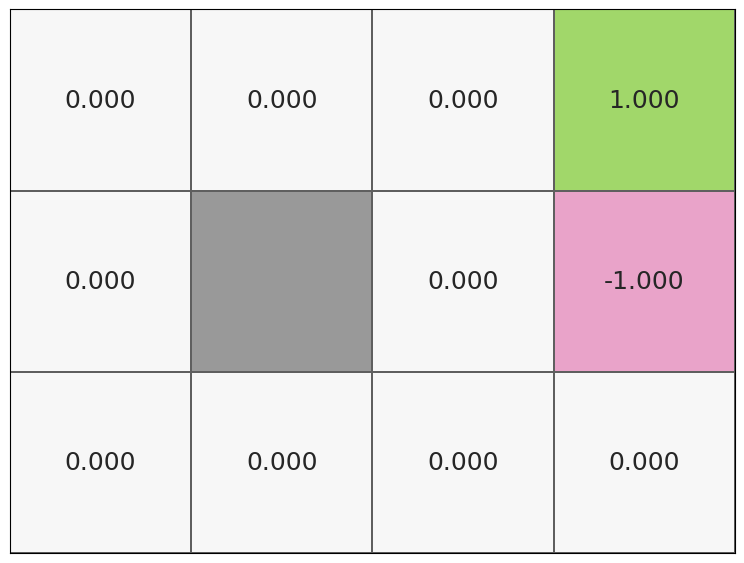

In [2]:
maze_config = {
    'size': (3, 4),
    'walls': [(1,1)],
    'terminal_states': [(0,3), (1,3)],
    'rewards': {
        (0,3): 1,
        (1,3): -1
    }
}
maze = Maze(maze_config)
plot_state_rewards(maze, ax=None)

## Markov Decision Process (MDP)

So, we represent the maze as a _Markov Decision Process_ (MDP).
MDP is a tuple $\left( \mathcal{S,A,P,R}, \gamma  \right)$, where

> $\mathcal{S}$ is the set of _states_<br>
$\mathcal{A}$ is the set of _actions_<br>
$\mathcal{P}$ defines the _transition probabilities_ between states<br>
$\mathcal{R}$ is the _reward function_ and<br>
$\gamma$ is a discount factor

We cover each of these briefly in the following.

In addition to the environment, we typically envision an _agent_, a decision maker navigating the maze environment one step at a time, trying the reach a goal, like finding a terminal state and, especially in the case of reinforcement learning, trying to learn the desired behavior from experience. 

### States

The states in the case of a maze environment are the grid positions within the maze which the agent can reach - the light gray squares in the above picture, as well as the terminal states marked with green and red. 

Squares blocked by walls (dark grey ones) are not states of the MDP representing the maze as they cannot be entered. 

As can be seen from the above code snippet, in the implementing code the states are indexed by `(x,y)`-coordinate tuples, starting from `(0,0)` in the top left corner. 

### Actions

The set of available actions are NORTH, EAST, SOUTH and WEST. 

For instance, taking action NORTH in state `(x,y)` would mean that the agent attempts to move to state with index `(x-1,y)`. Similarly action EAST would mean attempted movement to state `(x,y+1)`

The available actions are the same in all states, but attempting to move against a wall or outside of the maze will result in staying in the current state. 

Movement within the maze is noisy, however. Attempt to move to certain direction (e.g. _north_) may result in ending up left of the intended direction (e.g. _west_ if intended direction was _north_), or right of the direction (e.g. _east_).

The fact that the environment is stochastic is a key point for dynamic programming and reinforcement learning. If there was no uncertainty, the problem of determining optimal actions would be trivial. This uncertainty is modeled as _transition probablities_.

### Transition probabilities

For a Markov Decision Process, transition probabilities $P\left({s}'\vert s,a \right) = \mathbb{P}\!\left ( S_{t+1}={s}'\vert S_{_{t}}={s}_{t},A_{_{t}}={a}_{t} \right )$ are assumed to follow Markov property: The probabilities depend only on current state and action:

\begin{equation*}
\mathbb{P}\!\left({S}_{t+1}={s}'\vert {s}_{t:0},{a}_{t:0} \right) = \mathbb{P}\!\left ( S_{t+1}={s}'\vert S_{_{t}}={s}_{t},A_{_{t}}={a}_{t} \right )
\end{equation*}

As defined, we assume a perfect model of the environment. Thus, we need to be able to determine the transition probablities for different actions and states of the maze. 

For the maze at hand, transition probabilities can be deducted considering noisy movement within the maze, characterized by parameter $noise$: 

The agent will successfully move to intended direction with probablity

$ P_{straight} = 1 - noise$

And agent ends up left or right of the intended direction with equal probabilities

$ P_{left} = P_{right} =  noise \;/\; 2 $

As an example, consider the two-state maze shown in the following image:

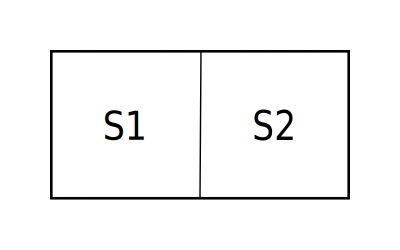

In [3]:
SVG(filename='img/simple_square_maze.svg')

Assuming $noise=0.2$ and attempting to take action NORTH in state S1 would result in following transition probabilities and state-transition diagram (for clarity, shown only for action NORTH):

\begin{equation*}
\mathbb{P}\left ( S_{t+1}=S_{1}\vert S_{_{1}}=S_{1},A=NORTH \right )=0.8+0.1=0.9
\end{equation*}

\begin{equation*}
\mathbb{P}\left ( S_{t+1}=S_{2}\vert S_{_{1}}=S_{1},A=NORTH \right )=0.1
\end{equation*}

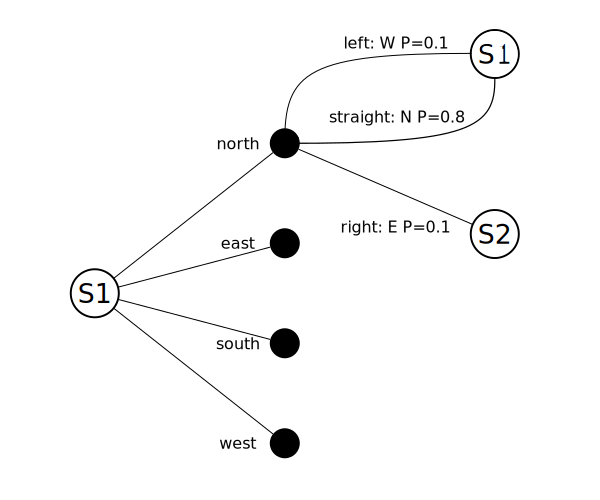

In [4]:
SVG(filename='img/noisy movement_example.svg')

### Reward function

Reward function $\mathrm{R}:\mathcal{S}\times\mathcal{A}\times\mathcal{S} \rightarrow \mathbb{R}$ defines the numerical value of reward received, $R_{t+1} = r\left( s,a,{s}'\right)$, when $S_{t}=s,A_{t}=a,S_{t+1}={s}'$. That is to say, reward received when in state $s$, the agent selects action $a$ and is transitioned to next state ${s}'$. Note the convention of associating the received reward with time step $t+1$.

Although other approaches are common, we consider rewards deterministic (when $s,a$ and ${s}'$ are known, that is) and prefer the three-argument function notation, stating explicitly that the reward received when entering the subsequent state ${s}'$ depends on that state, but also on previous state $s$ and action $a$ chosen in the previous state. 

The expected reward received for state-action pair $s,a$ depends on the transition probabilities of the MDP: 

\begin{equation*}
\mathbb{E}\!\left ( R_{t+1}\vert S_{t}=s,A_{t}=a\right ) =
\sum_{{s}'\in\mathcal{S}}
P\left( {s}' \vert s,a \right )
r\left ( s,a,{s}' \right ) 
\end{equation*}


However, for the simple maze illustrated earlier, the reward just depends on the state entered. In the examples that follow, we typically use reward of -1 and 1 for entering bad and good terminal states, respectively and zero for entering all other states.

In addition, there can be a constant _living cost_ that is added to reward in each time step. Living cost could represent the price the agent pays for exploring the maze (if negative), or reward the agent gets for surviving in the environment (if positive).


### Discount factor

Finally, the discount factor $\gamma$, $0 \leq \gamma\leq 1$, defines how future rewards are discounted when considering discounted returns.

## Policies and value functions

In addition to concepts introduced for a Markov Decision Process above, we still need to briefly discuss policies and value functions to set the stage for the application of dynamic programming methods and value iteration algorithm in particular.

We could consider policies and value functions to be related to an agent: Value function defining how the agent values different states of the environment, policy defining how the agent acts in the environment.

### Policies

Policy $\mathrm{\pi}:\mathcal{S}\rightarrow \mathcal{A}$ defines a mapping from each state to an action. In the following, we consider only _deterministic policies_, so that function $\pi \left( s\right)$ returns the action $a$ for state $s$ according to policy $\pi$. As the policy formulated this way does not change over time, it is considered a _stationary policy_.

In the case of _stochastic policies_, we would use notation $\pi \left( a\vert s\right)$ to denote the probablity of selecting action $a$ in state $s$ when following policy $\pi$.

The following image illustrates a policy. An action, although randomly selected in this case from (NORTH, EAST, SOUTH, WEST), is associated with each state of the MDP, resulting in a deterministic policy. 

There would be in total $\left |\mathcal{A}\right |^{\left |\mathcal{S}\right |}$ policies, or 262 144 different different policies in the case of the canonical maze, considering that there no action can be selected in terminal states.

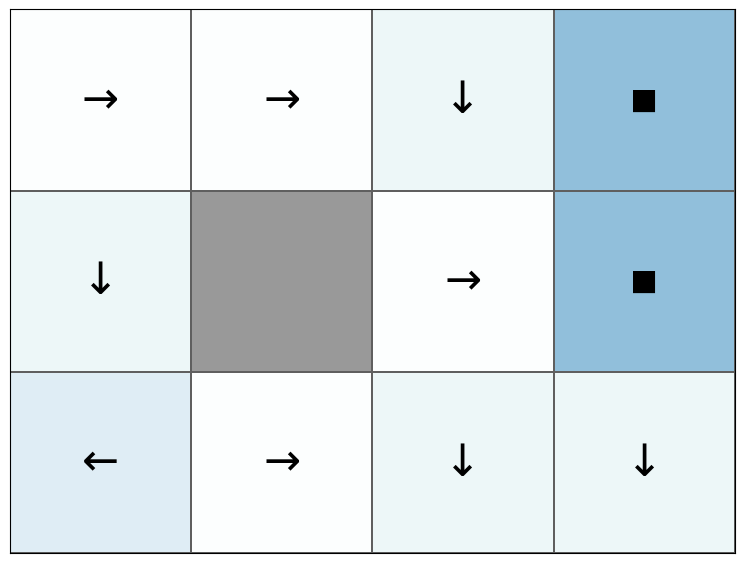

In [5]:
policy = {state: np.random.choice(Movement.actions) for state in maze.get_iterator("states") if not maze.terminal[state]}
plot_policy_actions(maze, policy)

### Value function

Consider that an agent, starting in state $S_{t}$ explores the maze by taking an action $A_{t}$, receives the reward $R_{t+1}$ and is transitioned to state $S_{t+1}$. The agent then continues exploring, taking action $A_{t+1}$, and, in similar fashion, receives reward $R_{t+2}$ and is transitioned to state $S_{t+2}$, thus creating a sequence:

\begin{equation*}
S_{t},A_{t},R_{t+1},S_{t+1},A_{t+1},R_{t+2},S_{t+2},A_{t+2},R_{t+3}...
\end{equation*}


Discounted return, or _utility_ from time step $t$ onwards is the sum of discounted rewards received:

\begin{equation*}
U_{t}=R_{t+1}+\gamma R_{t+2}+\gamma^{2} R_{t+3}+\gamma^{3} R_{t+4} + ... 
\end{equation*}

If the agent was following a policy, then in each state $s$, the agent would select the action $\pi \left( s\right)$ defined by that policy and a sequence of states, actions and rewards would arise in similar fashion. 

The _state-value function_ of a state $s$ under policy $\pi$, denoted $V^{\pi }$, is the expected discounted return when following the policy from state $s$ onwards:

\begin{equation*}
V^{\pi }\left ( s \right ) =
\mathbb{E}_{\pi}\!\left [
    U_{t}\vert S_{t}=s
\right ]
\end{equation*}

Substituting $U_{t}$ and manipulating, we get:

\begin{align*} 
V^{\pi }\!\left ( s \right ) 
&=
\mathbb{E}_{\pi}\!\left [
 R_{t+1}+\gamma R_{t+2}+\gamma^{2} R_{t+3}+\gamma^{3} R_{t+4}... 
\vert S_{t}=s
\right ]
\\
&=
\mathbb{E}_{\pi}\!
\left [
    R_{t+1}+\gamma \left( R_{t+2}+\gamma R_{t+3}+\gamma^{2} R_{t+4}...    \right)
    \vert S_{t}=s
\right ]
\\
&=
\mathbb{E}_{\pi}\!
\left [
    R_{t+1}+\gamma U_{t+1}
    \vert S_{t}=s
\right ]
\\
&=
\mathbb{E}_{\pi}\!
\left [
    R_{t+1}+\gamma V^{\pi}\left ( S_{t+1} \right )
    \vert S_{t}=s
\right ]
\end{align*}

Where the last step applies the [Law of iterated expectations](https://en.wikipedia.org/wiki/Law_of_total_expectation) as:

\begin{equation*}
\mathbb{E}_{\pi}[V^{\pi}(S_{t+1}) \,|\,S_t=s ] = \mathbb{E}_{\pi}[\mathbb{E}_\pi[U_{t+1} | S_{t+1}={s}'] \,|\,S_t=s ] = \mathbb{E}_\pi[U_{t+1} | S_{t}=s]
\end{equation*}

State value of $s$ thus decomposes to, first, expected immediate reward received when selecting the action $\pi \left( s\right)$ as defined by the policy and, second, to expected discounted value of the successor state. This reqursive relationship that defines the relation of the value of a state and its successor states is the _Bellman expectation equation_ for $V^{\pi }$.

Applying the MDP constructs laid out above and expanding the expectation gives:

\begin{equation*}
V^{\pi }\!\left ( s \right ) =
\sum_{{s}'\in\mathcal{S}}
P\left( {s}' \vert s,\pi \left(s \right ) \right )
\left( r\left (s,\pi \left(s \right ),{s}'\right )  + \gamma 
V^{\pi } \left ( {s}' \right )  \right ) 
\end{equation*}

Similarly to $V^{\pi }$, we can define $Q^{\pi }$, the _action-value function_ for policy $\pi$ 


\begin{align*} 
Q^{\pi }\!\left ( s, a \right ) 
&=
\mathbb{E}_{\pi} \left [
    U_{t}\vert S_{t}=s, A_{t}=a
\right ]
\\
\\
&= 
\sum_{{s}'\in\mathcal{S}}
P\left( {s}' \vert s,a \right )
\left( r\left (s,a,{s}'\right )  + \gamma 
V^{\pi} \left ( {s}' \right )  \right )
\end{align*}


For a state-action pair, action-value function $Q^{\pi }\!\left ( s, a \right )$ defines the expected utility when starting in state $s$, performing action $a$ and following policy $\pi$ thereafter. After receiving the immediate reward $r\left (s,a,{s}'\right )$ the discounted future reward as defined by the successor state value $\gamma V^{\pi} \left ( {s}' \right )$ is received. This illustrates the recursive relation between $Q^{\pi }$ and $V^{\pi }$.

### Optimal value function

Optimal value function is one that gives the best expected utility for each state or state-action pair, $s \in \mathcal{S}$ and $a \in \mathcal{A}$, over all policies, defined for state- and action-value functions as:

\begin{equation*}
V^{\ast}\!\left ( s \right ) = \underset{\pi}{\mathrm{max}}\; V^{\pi}\!\left(s\right )
\end{equation*}

\begin{equation*}
Q^{\ast}\!\left ( s, a \right ) = \underset{\pi}{\mathrm{max}}\; Q^{\pi}\!\left(s , a\right )
\end{equation*}

So $V^{\ast}\!\left ( s \right )$ gives the expected return for being in state $s$ and following optimal policy, while $Q^{\ast}\!\left ( s, a \right )$ gives the expected return for taking action $a$ in state $s$ and following optimal policy thereafter. 

_Bellman optimality equation_ for $Q^{\ast}$ defines a decomposition to immediate return and optimal action-value of the successor state:

\begin{equation*}
Q^{\ast}\!\left ( s, a \right ) 
=
\mathbb{E}_{\pi}
\left [
R_{t+1}
+
\gamma\;
\underset{{a}'}{\mathrm{max}}\;
Q^{\ast}\!
\left (
S_{t+1},{a}'
\right )
\vert S_{t}=s, A_{t}=a
\right ]
\end{equation*}

As the optimal value for state $V^{\ast}$ must equal the expected utility taking the best action in state $s$ and following optimal policy from that point onward, we can write:

\begin{equation*}
V^{\ast}\! \left ( s \right ) = \underset{a}{\mathrm{max}}
\:
Q^{\ast}\! \left ( s,a \right )
\end{equation*}

So, for optimal action-value function we have a similar relation as previously discussed for action-value function $Q^{\pi }$ where we refer to the optimal _state-value function_ of the successor state:

\begin{align*} 
Q^{\ast}\!\left ( s, a \right )
&=
\mathbb{E}_{\pi}
\left [
    R_{t+1}+\gamma V^{\ast}\left ( S_{t+1} \right )
    \vert S_{t}=s, A_{t}=a
\right ]
\\
\\
&= 
\sum_{{s}'\in\mathcal{S}}
P\left( {s}' \vert s,a \right )
\left( R\left (s,a,{s}'\right )  + \gamma 
V^{\ast} \left ( {s}' \right )  \right )
\end{align*} 

Combining the above, the optimal state-value function can be expressed as:

\begin{equation*}
V^{\ast}\!\left ( s \right ) = \underset{a}{\mathrm{max}}
\sum_{{s}'\in\mathcal{S}}
P\left( {s}' \vert s,a \right )
\left( r\left (s,a,{s}'\right )  + \gamma 
V^{\ast} \left ( {s}' \right )  \right )
\end{equation*}

### Optimal policy

We consider a policy $\pi_{1}$ to be equal or better than some other policy $\pi_{2}$, if the state-value in all states is at least as good for $\pi_{1}$

\begin{equation*}
\pi_{1} \geq \pi_{2} \; \Leftrightarrow \; V^{\pi_{1}}(s) \geq V^{\pi_{2}}(s), \;\forall s \in \mathcal{S}
\end{equation*}

For any MDP, there always exists an _optimal deterministic policy_ that is at least as good as all other policies:

\begin{equation*}
\pi^{\ast} \geq \pi, \; \forall \pi
\end{equation*}

There can be multiple optimal policies, but all optimal policies achieve the optimal value functions $V^{\ast}(s)$ and $Q^{\ast}(s,a)$.

So, finally, optimal policy is the policy (or one of the best policies) that gives the best value for each state:

\begin{equation*}
\pi^{\ast}\!\left ( s \right ) = \underset{a}{\mathrm{argmax}}\; 
\sum_{{s}'\in\mathcal{S}}
P\left( {s}' \vert s,a \right )
\left( R\left (s,a,{s}'\right )  + \gamma 
V^{\ast} \left ( {s}' \right )  \right )
\end{equation*}

## Policy evaluation and update rules

The task of computing state-value function for states under policy $\pi$ is called _policy evaluation_. Considering the formula for $V^{\pi }$ above, we see that we we have an equation for each state $V^{\pi}\!\left ( s \right )$ that refers to values of subsequent states. This gives as a system of $\left |\mathcal{S}\right |$ simultaneous linear equations with $\left |\mathcal{S}\right |$ unknown state values $V^{\pi}\!\left ( s \right )$ which can be solved with a suitable standard method. 

### Bellman expectation backup

An iterative solution method for policy evaluation can be derived by using the Bellman expectation equation for state-values as an update rule, also called _Bellman expectation backup_: 

\begin{equation*}
V^{\pi}_{k+1 }\!\left ( s \right ) =
\sum_{{s}'\in\mathcal{S}}
P\left( {s}' \vert s,\pi \left(s \right ) \right )
\left( r\left (s,\pi \left(s \right ),{s}'\right )  + \gamma 
V^{\pi}_{k}\left ( {s}' \right )  \right ) 
\end{equation*}

We update state-value $V^{\pi}_{k+1 }\!\left ( s \right )$ based on old values of the successor states $V^{\pi}_{k}\left ( {s}' \right )$ and the expected immediate rewards. We would sweep thought the state set, updating each state in turn (a synchronous backup). This is called _iterative policy evaluation_ and is guaranteed to converge to $V^{\pi}$.

Later, we consider a matrix formulation for policy evaluation (rather than the iterative solution discussed above) in the implementation of policy iteration algorithm, see [here](maze_policy_iteration.ipynb#Matrix-implementation-of-policy-evaluation).

### Bellman optimality backup

In similar fashion, to find an optimal policy we can derive an update rule from Bellman optimality equation as:

\begin{equation*}
V_{k+1 }\!\left ( s \right ) =
\underset{a}{\mathrm{max}}
\:
\sum_{{s}'\in\mathcal{S}}
P\left( {s}' \vert s,a \right )
\left( r\left (s,a,{s}'\right )  + \gamma 
V_{k}\left ( {s}' \right )  \right ) 
\end{equation*}

This _Bellman optimality backup_ is the building block for value iteration algorithm exhibited in the following.

## Value iteration algorithm

The goal for Value iteration algorithm is to find the optimal state-value function $V^{\ast}$ for a fully defined MDP and derive the corresponding optimal policy $\pi^{\ast}$ from the value function.

The algorithm performs synchronous sweeps of the state-space and updates each state in turn by applying the Bellman optimality backup. 

For arbitary $V_{0}$, value iteration algorithm can be shown to convergence to $V^{\ast}$ for discounted finite MDPs if $\gamma < 1$ or if the state-action-reward sequences (episodes) are guaranteed to be finite. In practice, we consider the algorithm has converged when the maximum change between two subsequent value functions is smaller than some predefined threshold $\theta$.

Once the algorithm has converged to a (near) optimal solution, we determine the optimal policy $\pi^{\ast}$ corresponding to the value function by looping through all states and determining the action that maximizes the expected returns from that state.

Pseudocode for the algorithm could stand as follows:

<span style="font-family: monospace;">
    
> **Value iteration:** 
>   
> initialize $\theta > 0$, $k =0$ and $V_{0}\left ( s \right ) \in \mathbb{R}$ for all $S$
> 
> loop: 
>> for each $s \in \mathbb{S}$:
>>> update $
V_{k+1 }\!\left ( s \right ) \leftarrow
\underset{a}{\mathrm{max}}
\:
\sum_{{s}'\in\mathcal{S}}
P\left( {s}' \vert s,a \right )
\left( r\left (s,a,{s}'\right )  + \gamma 
V_{k}\left ( {s}' \right )  \right ) 
$
>>
>> $k = k + 1$
>
> until convergence, $\left \| V_{k+1} - V_{k} \right \|_{\infty}<\theta$
> 
> return $V^{\ast} \approx V_{k+1}$
>
>
> **Policy extraction:** 
>    
> for each $s \in \mathbb{S}$:
>> extract policy, $
\pi^{\ast}\!\left ( s \right ) \leftarrow \underset{a}{\mathrm{argmax}}\; 
\sum_{{s}'\in\mathcal{S}}
P\left( {s}' \vert s,a \right )
\left( R\left (s,a,{s}'\right )  + \gamma 
V^{\ast} \left ( {s}' \right )  \right )
$
> 
> return $\pi^{\ast}$

</span>

For this implementation, we need to maintain two copies of state values; current values $V_{k}$ and updated values $V_{k+1}$. Indeed, we use the updated values only during the next iteration, when all states have been visited and updated.

It is good to note that there is no need to represent the policy during execution of the algorithm. The updates refer to state values only, and policy is only extracted at the end.
 
Computational complexity is $O(\left |\mathcal{A}\right |\left |\mathcal{S}\right |^{2})$ per iteration for $\left |\mathcal{A}\right |$ actions and $\left |\mathcal{S}\right |$ states.

## Value iteration implementation

In the following, we illustrate an implementation of Value Iteration algorithm. As the goal is to illustrate the algorithm using the maze as an example, no effort has been put into generalizing the implementation. Rather, we utilize `Maze` specific concepts such as `Movement` directly.

`get_best_action` enables calculating the state-value corresponding to best action from that state for the update step:

\begin{equation*}
V_{k+1 }\!\left ( s \right ) \leftarrow
\underset{a}{\mathrm{max}}
\:
\sum_{{s}'\in\mathcal{S}}
P\left( {s}' \vert s,a \right )
\left( r\left (s,a,{s}'\right )  + \gamma 
V_{k}\left ( {s}' \right )  \right ) 
\end{equation*}

and is also used for extracting the best actions for optimal policy:

\begin{equation*}
\pi^{\ast}\!\left ( s \right ) \leftarrow \underset{a}{\mathrm{argmax}}\; 
\sum_{{s}'\in\mathcal{S}}
P\left( {s}' \vert s,a \right )
\left( r\left (s,a,{s}'\right )  + \gamma 
V^{\ast} \left ( {s}' \right )  \right )
\end{equation*}

Note that the implementation is lazy; For several equally good actions, the first one is returned.

Note also that for our simple maze, the reward only depends on `s_prime`, the state entered, so `maze.rewards[s_prime]` is sufficient for finding the immediate reward.

In [6]:
def get_best_action(maze, movement, state, state_values):
   
    best_action = None
    best_value = -math.inf

    for action in movement.actions:

        val = 0

        for move_direction, p_move in movement.get_direction_probs(action):

            s_prime = movement.move_from(state, move_direction)

            reward = maze.living_cost + maze.rewards[s_prime]
            s_prime_value = state_values[s_prime]

            val += p_move * (reward + maze.gamma * s_prime_value)

        if val > best_value:
            best_value = val
            best_action = action

    return best_value, best_action

`extract_policy` sweeps through states and finds the optimal action for each state:

In [7]:
def extract_policy(maze, movement, state_values):
    
    policy = {}
    
    for state in maze.get_iterator("states"):
        
        if maze.terminal[state]:
            continue
        
        best_value, best_action = get_best_action(maze, movement, state, state_values)

        policy[state] = best_action
    
    return policy

`value_iteration_sweep`performs one iteration of the algorithm, sweeping through all states and updating the values in turn

In [8]:
def value_iteration_sweep(maze, movement, state_values):
    
    values = state_values.copy()
    
    for state in maze.get_iterator("states"):

        if maze.terminal[state]:
            continue
        
        best_value, _ = get_best_action(maze, movement, state, state_values)
        values[state] = best_value
        
    return values

For `distance` between two value functions, $V_{k+1}$ and $V_{k}$, we use the $\infty$-norm:

In [9]:
def distance(list1, list2):
    
    # for np.linalg.norm, ord=np.inf for vector x is max(abs(x))
    
    return np.linalg.norm(np.subtract(list1, list2), ord=np.inf) 

Finally, the entry point to main loop allows us to terminate either based on $\theta$ (`C_LIMIT`), or based on max number of iterations (`MAX_ITERS`), whichever is reached first. 

We can choose to plot values for each iteration by giving a suitable plotter function for `plotter` keyword argument, such as `plot_maze` utility function defined in Maze basis implementation notebook. In that case, we also extract the policy corresponding to the current value-function. As noted eaerlier, intermediate policies are not otherwise needed by the algorithm.

In [10]:
def value_iteration(maze, movement, initial_values, *, MAX_ITERS=10, C_LIMIT = 0.01, plotter=None):

    values = initial_values.copy()

    for i in range(0, MAX_ITERS):
        
        updated_values = value_iteration_sweep(maze, movement, values)
        
        if plotter:
            policy = extract_policy(maze, movement, updated_values)
            plotter(maze, updated_values, policy)

        previous_values_list = maze.get_as_list(values)
        updated_values_list = maze.get_as_list(updated_values)
        
        dist = distance(previous_values_list, updated_values_list)
        
        print(f"ROUND {i}, {dist}")

        if dist <= C_LIMIT:
            break

        values = updated_values
    
    return values

## Example: The Canonical maze

We illustrate the algorithm using the canonical maze as an example. We repeat the definition already given earlier.

First, we intialize the maze with two final states. We start with `gamma=1`, `living_cost = -0.04` and `noise=0.2`: 

In [11]:
maze_config = {
    'size': (3, 4),
    'walls': [(1,1)],
    'terminal_states': [(0,3), (1,3)],
    'rewards': {
        (0,3): 1,
        (1,3): -1
    }
}

In [12]:
maze = Maze(maze_config, gamma=1, living_cost = -0.04)
movement = Movement(maze, noise=0.2)

The maze would look as follows, with rewards diplayed for each state (taking in account the reward associated with entering the state as well as the living cost):

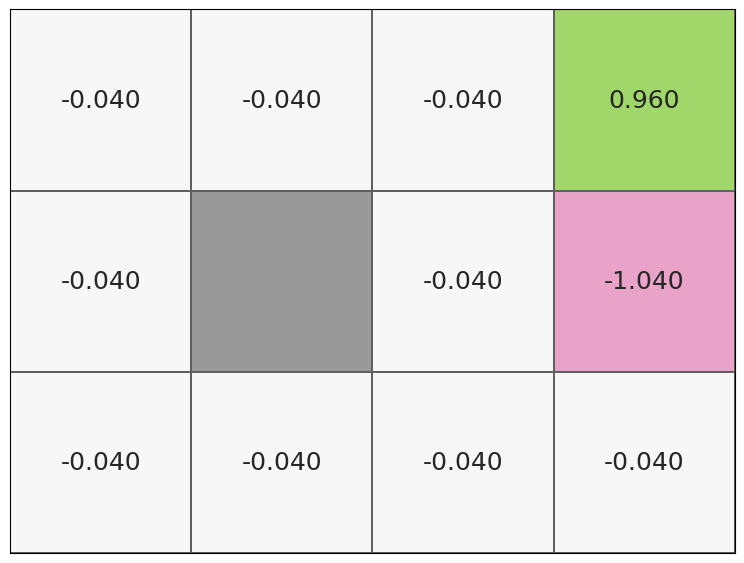

In [13]:
plot_state_rewards(maze)

We intialize the state-values to zero, and for illustration, extract the policy corresponding to initial values. Note that  displaying NORTH, the first action for all states not adjacent to a terminal state (with a non-zero reward), is a consequence of not actively resolving ties in the implementation.

{(0, 0): 0,
 (0, 1): 0,
 (0, 2): 0,
 (0, 3): 0,
 (1, 0): 0,
 (1, 2): 0,
 (1, 3): 0,
 (2, 0): 0,
 (2, 1): 0,
 (2, 2): 0,
 (2, 3): 0}

{(0, 0): 'NORTH',
 (0, 1): 'NORTH',
 (0, 2): 'EAST',
 (1, 0): 'NORTH',
 (1, 2): 'WEST',
 (2, 0): 'NORTH',
 (2, 1): 'NORTH',
 (2, 2): 'NORTH',
 (2, 3): 'SOUTH'}

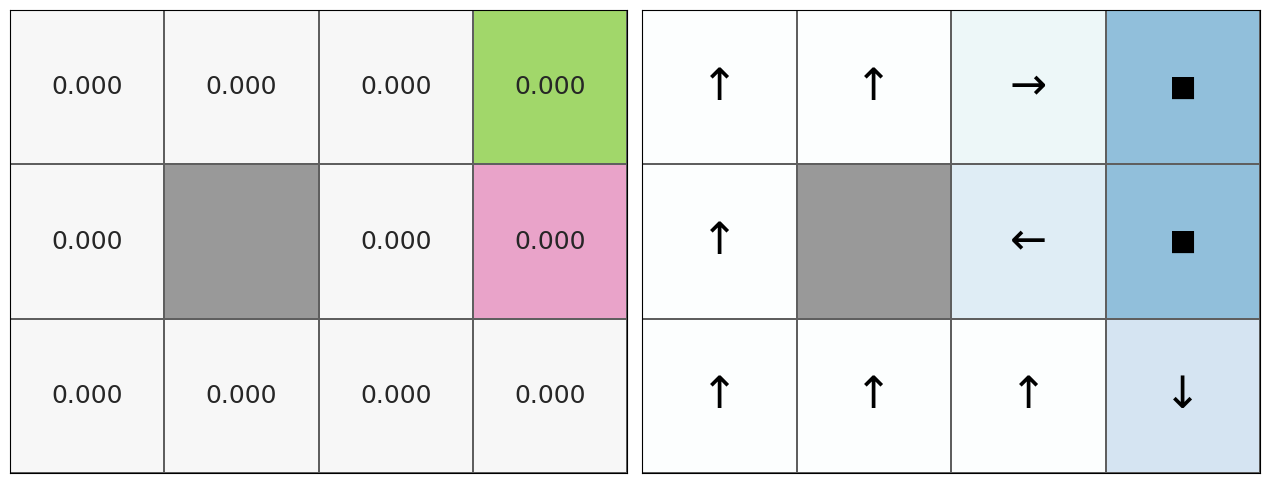

In [14]:
initial_values = { state:0 for state in maze.get_iterator("states") }
display(initial_values)

initial_policy = extract_policy(maze, movement, initial_values)
display({r:Movement.action_names[initial_policy[r]] for r in maze.get_iterator("states") if r in initial_policy})

plot_maze(maze, initial_values, initial_policy)

Now we are ready to run the algorithm. We set target as $\theta=0.0001$ and hope to converge in 50 iterations. `plot_maze` will be employed to display state-values and corresponding policy actions for each iteration step below.

We would expect the policy to converge to optimal policy faster than the state-values converge. This can be verified by comparing the images rendered during iterations.

ROUND 0, 0.76
ROUND 1, 0.6
ROUND 2, 0.4719999999999999
ROUND 3, 0.3696
ROUND 4, 0.322496
ROUND 5, 0.22240000000000004
ROUND 6, 0.14542848000000014
ROUND 7, 0.07915033599999999
ROUND 8, 0.05098588160000006
ROUND 9, 0.04350144511999998
ROUND 10, 0.028168144896000058
ROUND 11, 0.016857831628799946
ROUND 12, 0.00947977033727987
ROUND 13, 0.008293859824703986
ROUND 14, 0.007234680534944027
ROUND 15, 0.004668150556267681
ROUND 16, 0.002583969819715093
ROUND 17, 0.00135457817542195
ROUND 18, 0.0006911852371261906
ROUND 19, 0.00034648453452768013
ROUND 20, 0.00017134649995231843
ROUND 21, 8.37996274202224e-05


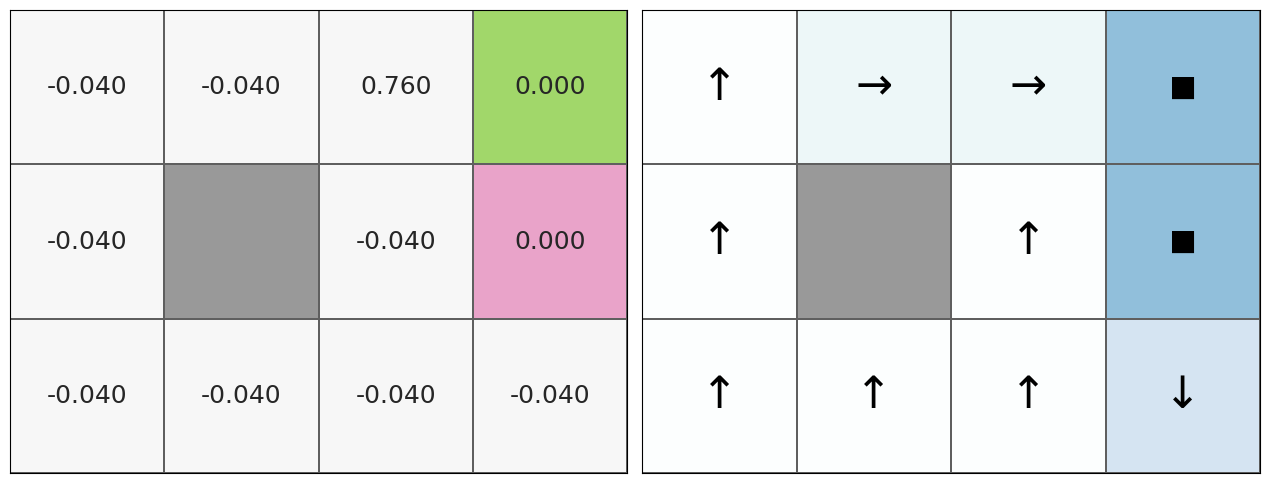

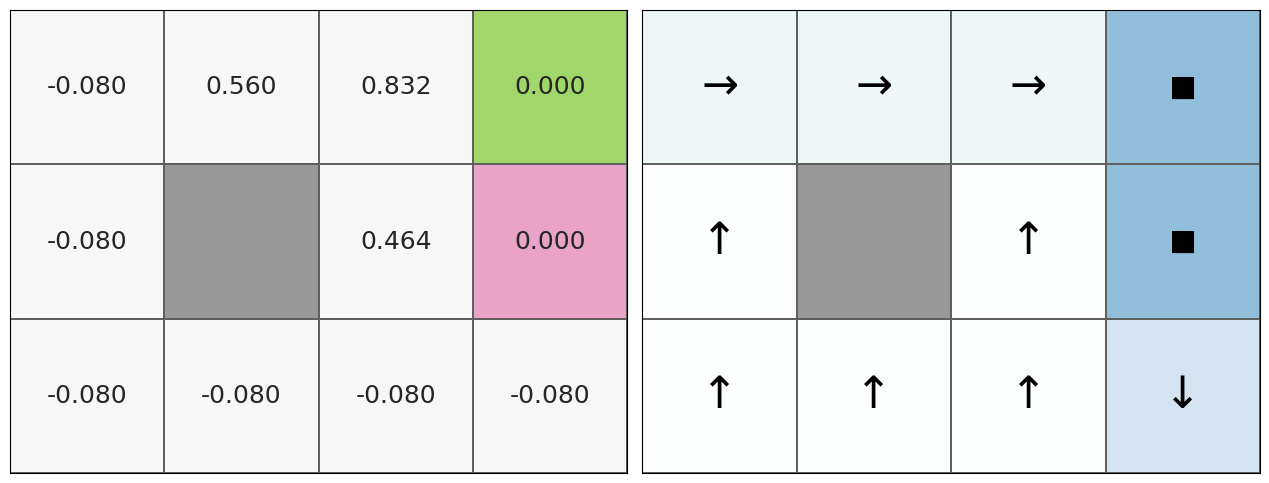

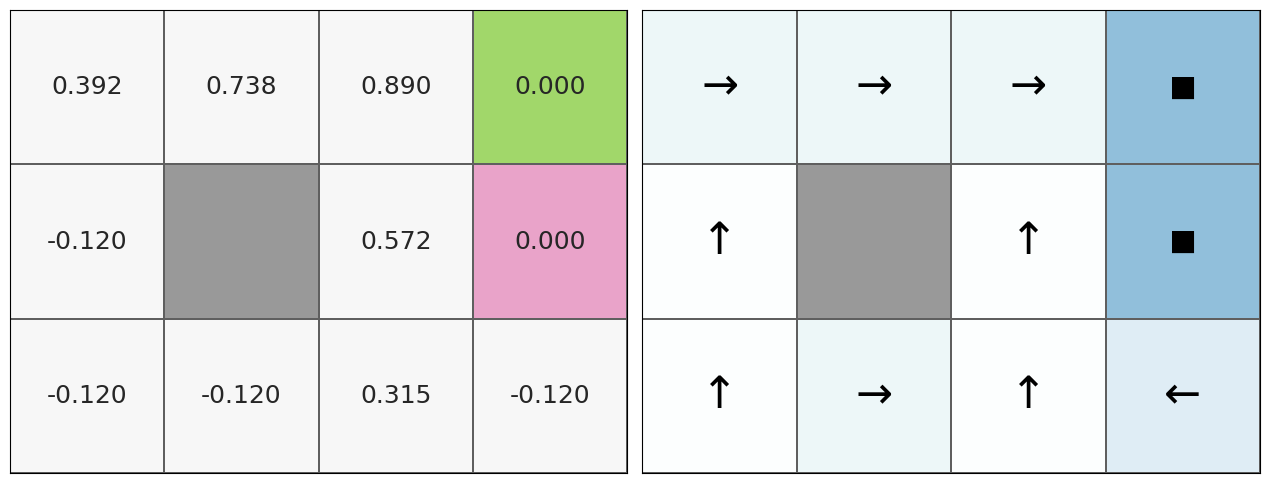

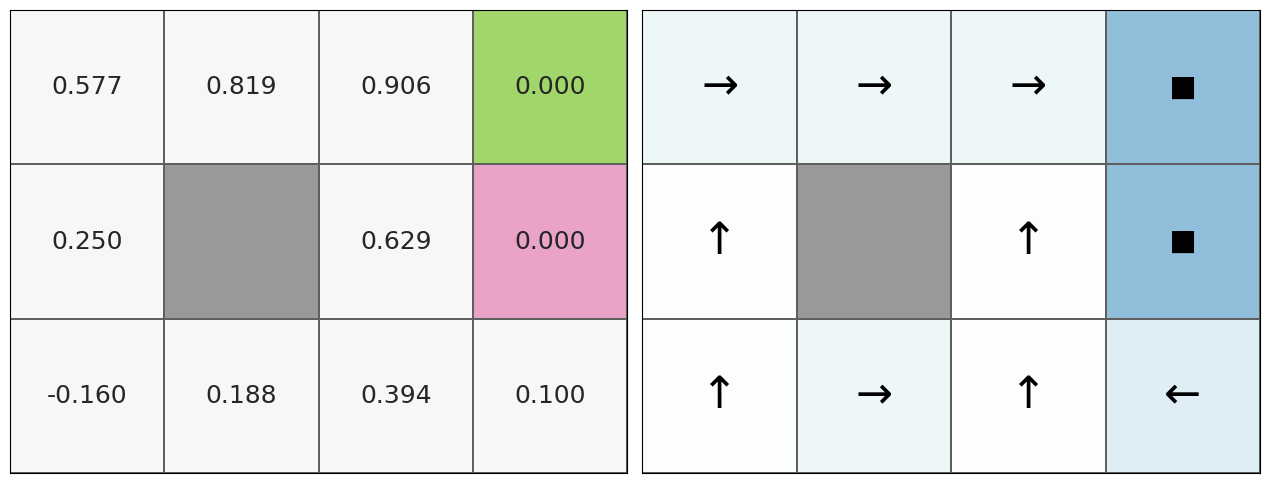

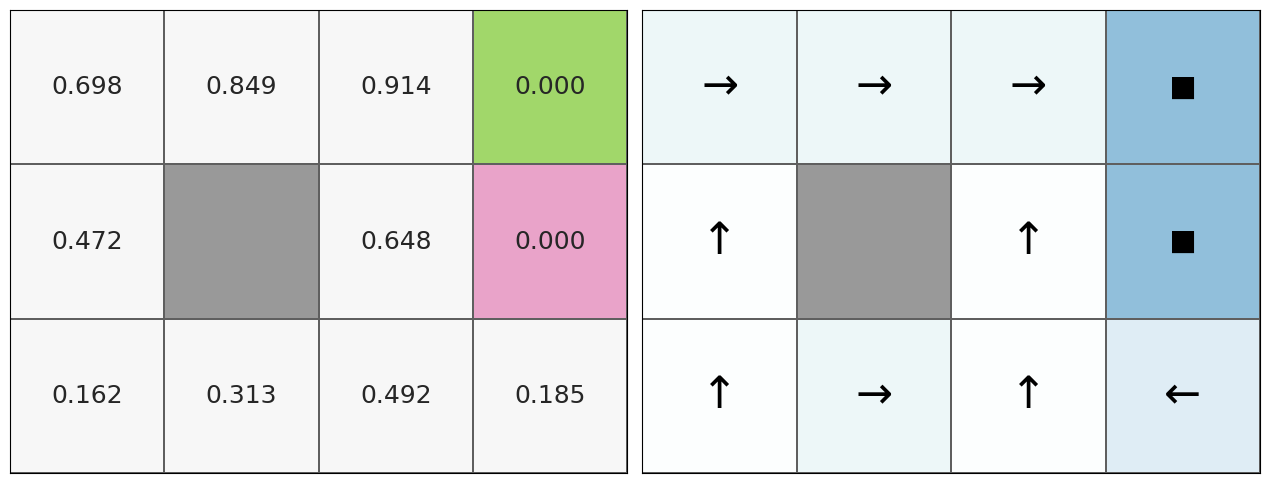

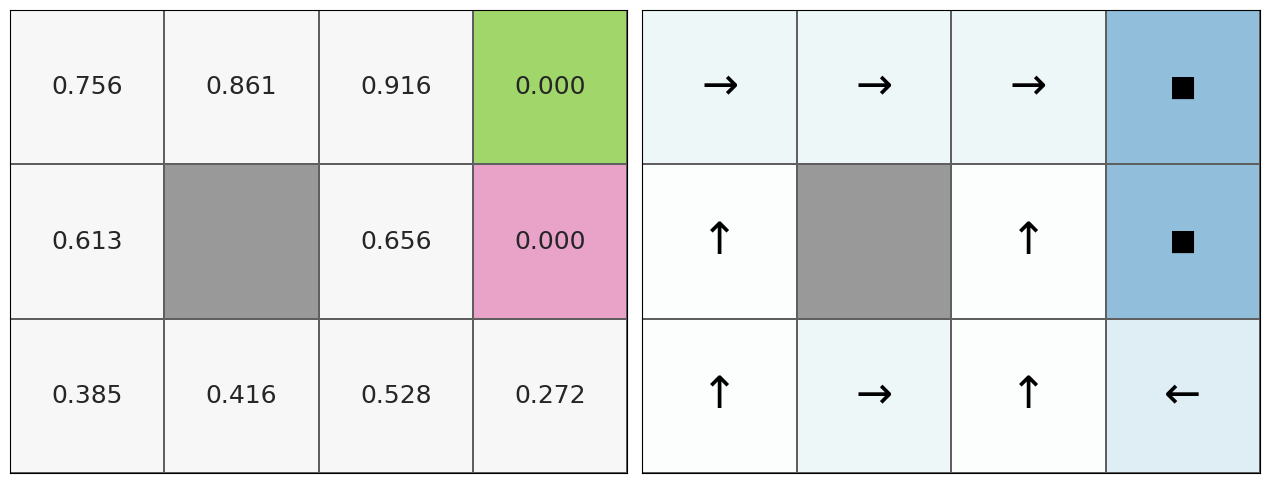

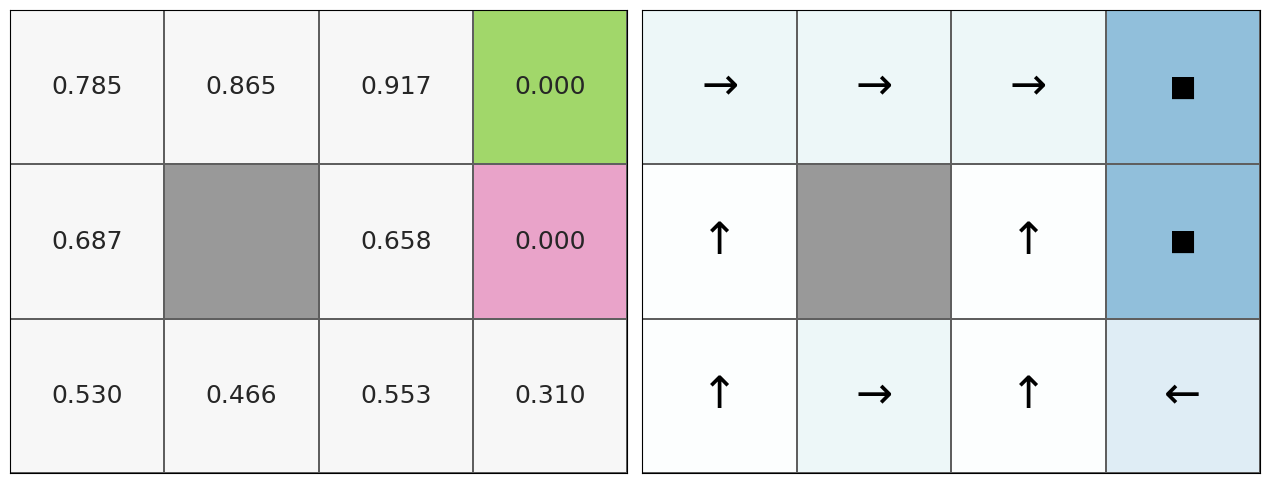

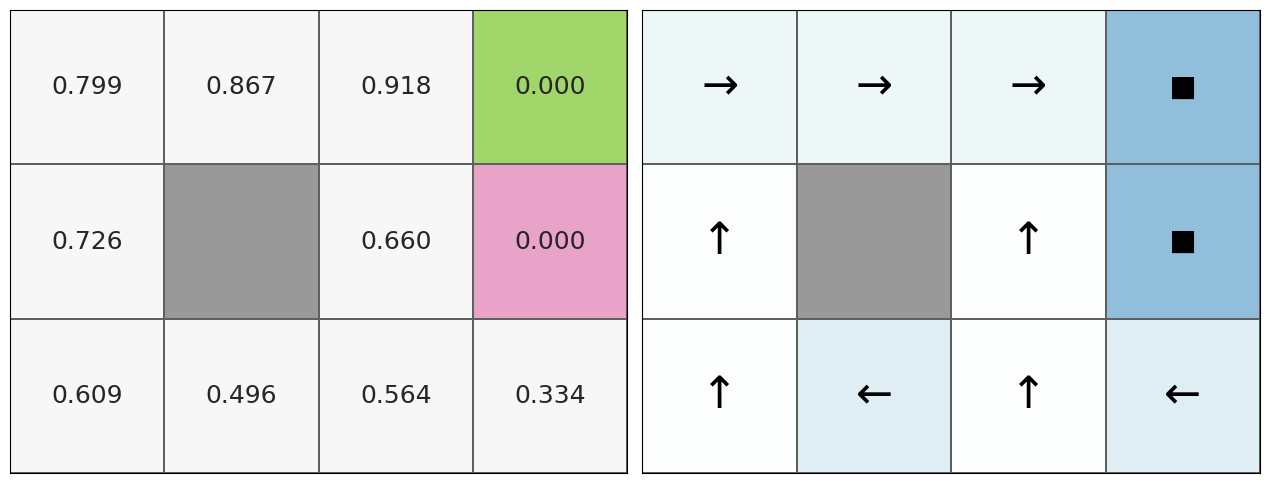

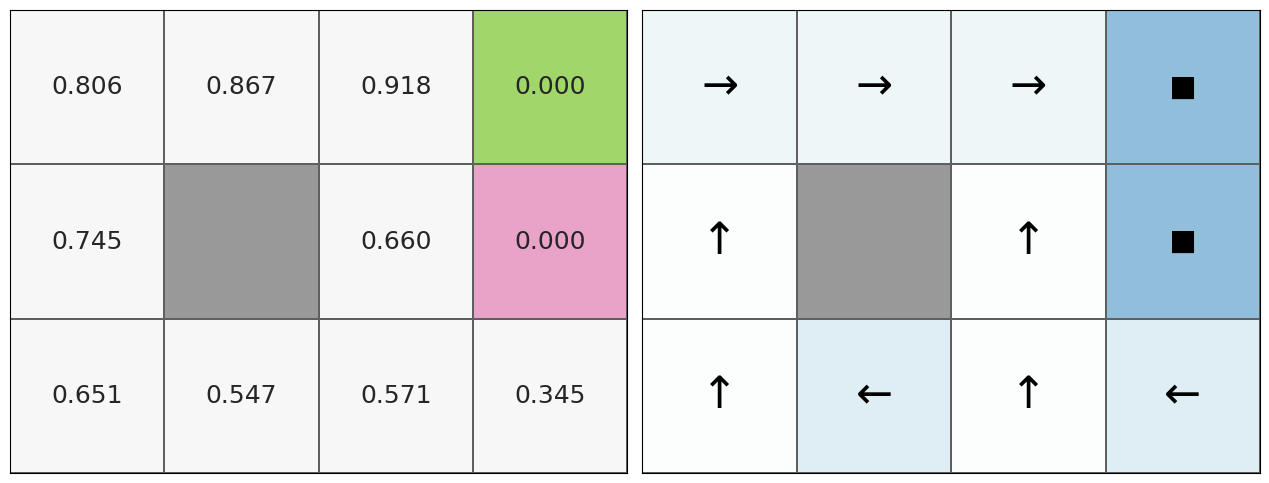

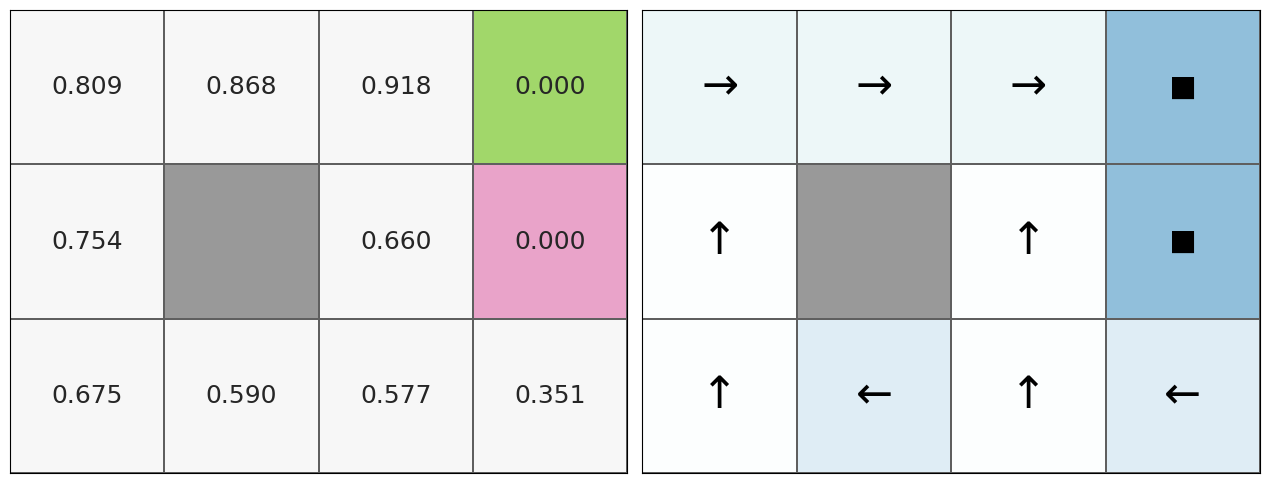

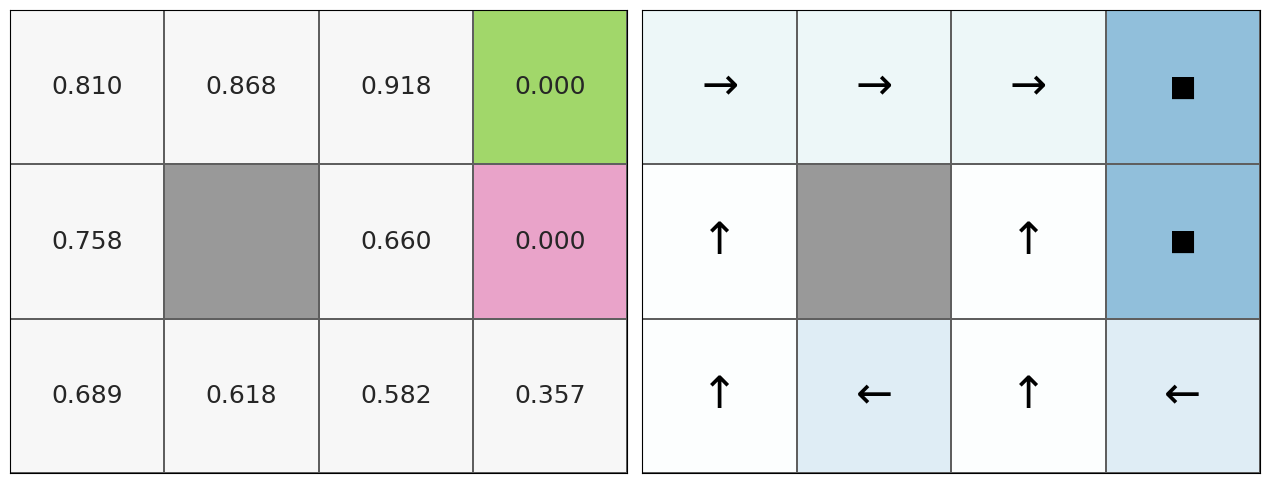

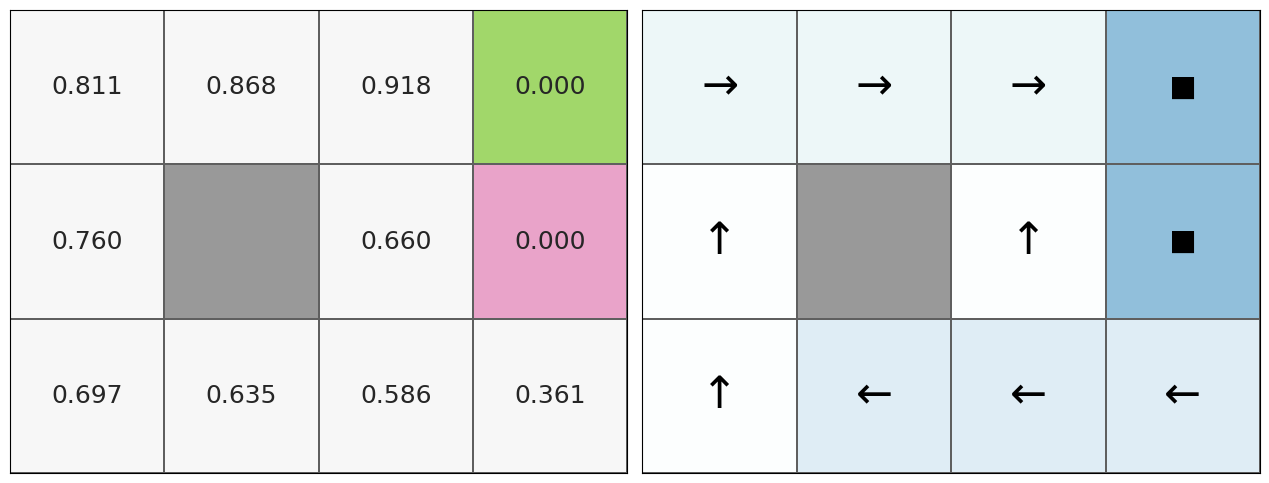

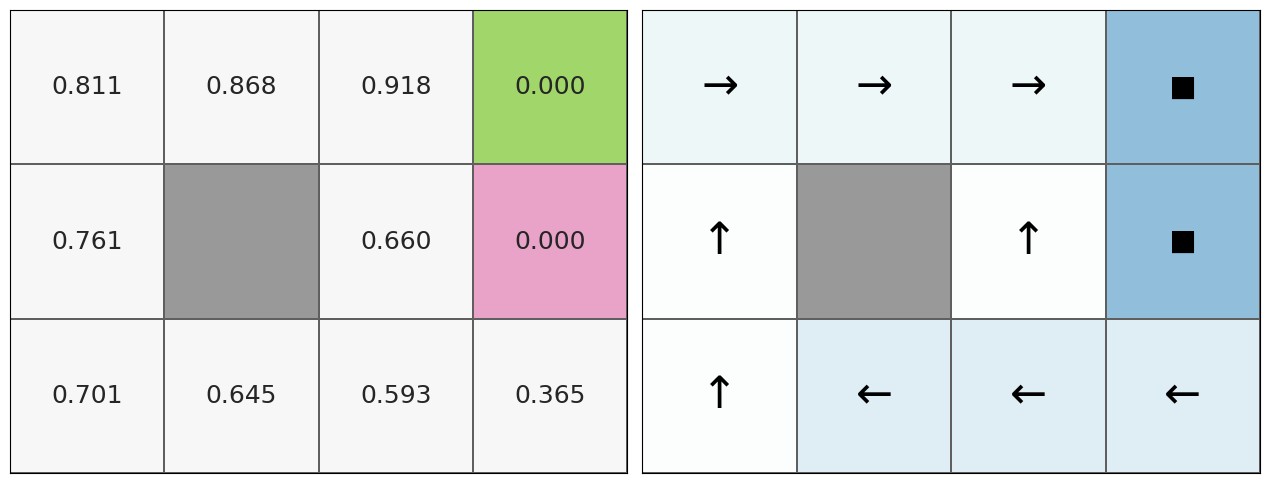

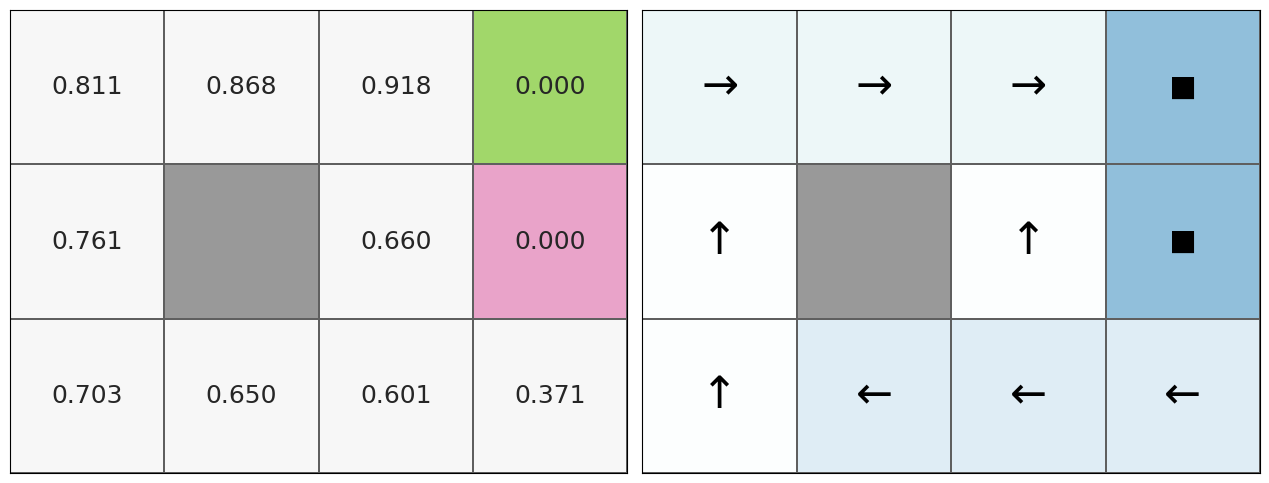

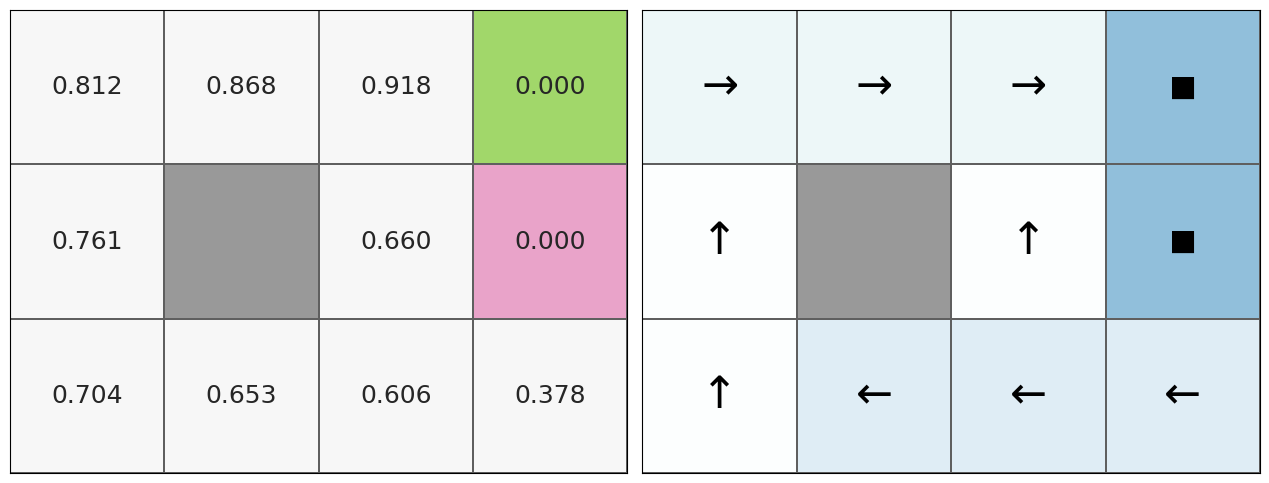

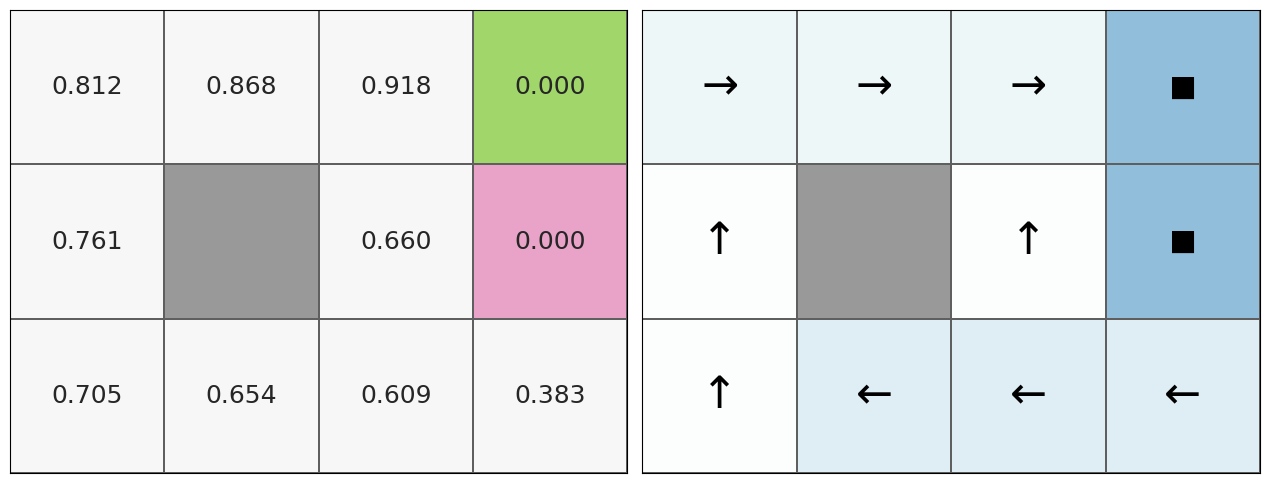

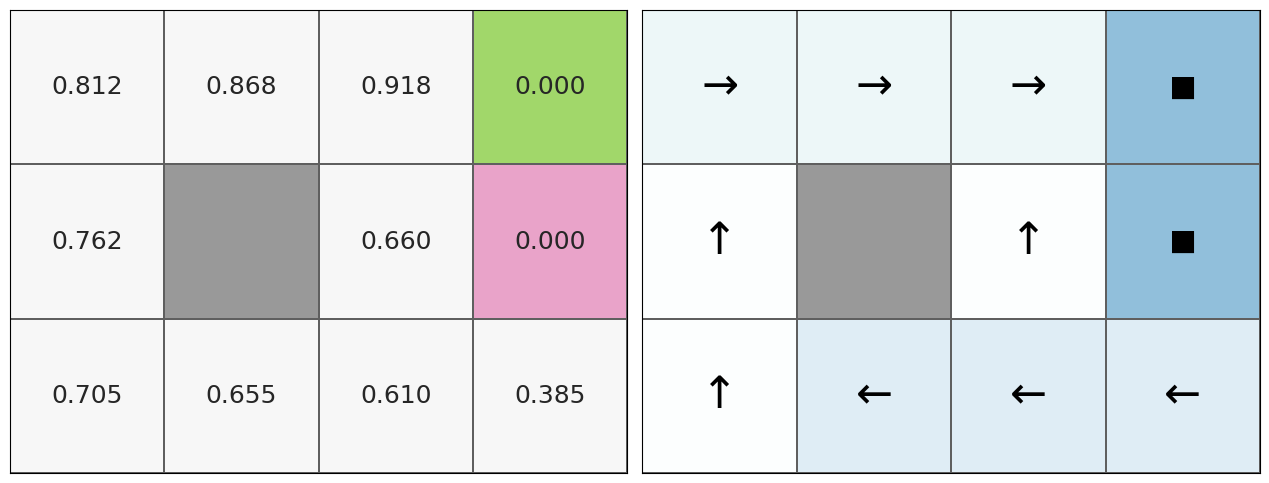

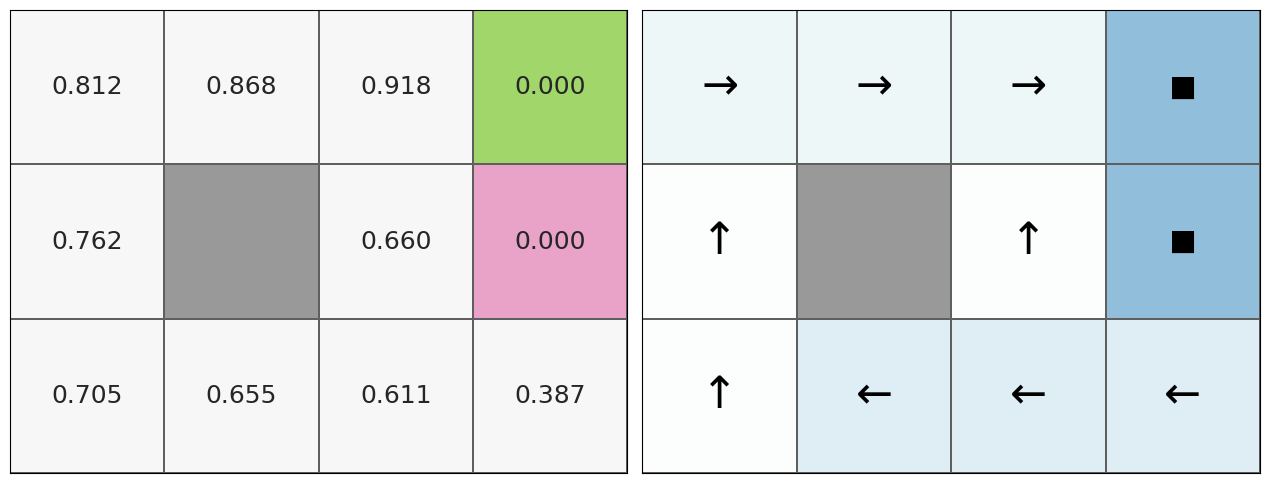

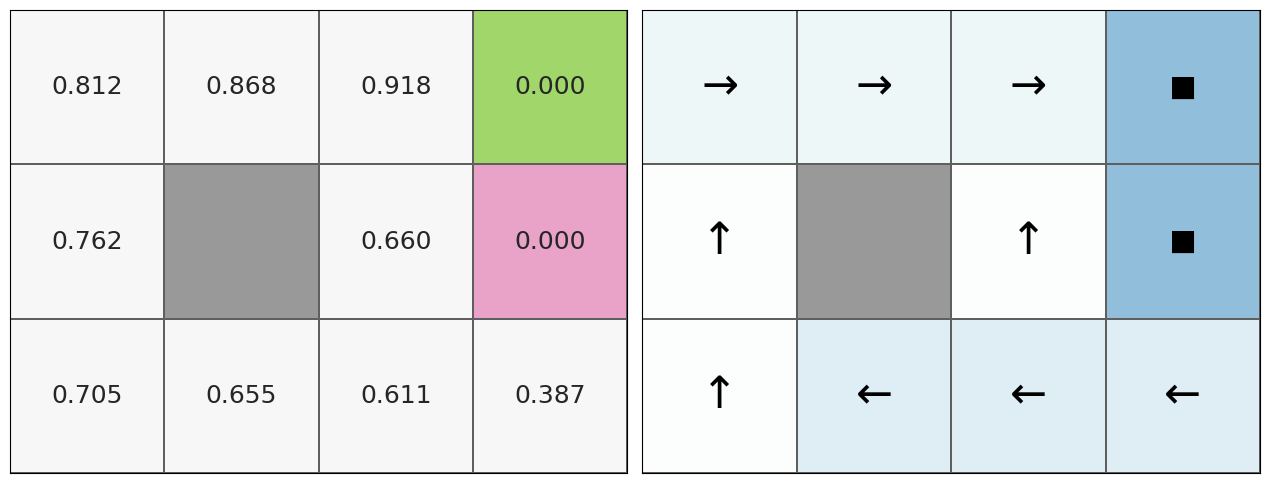

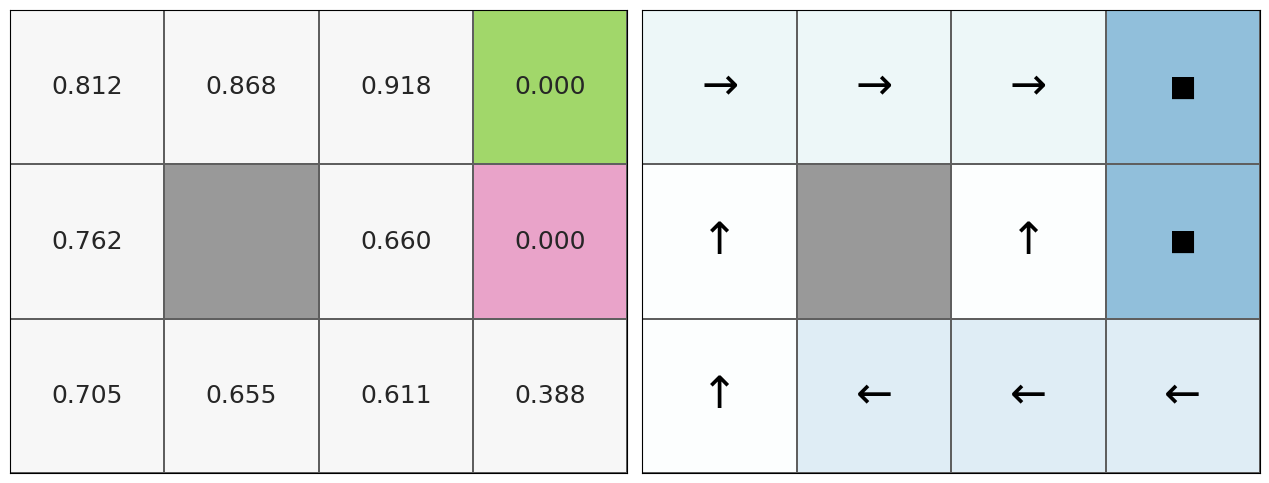

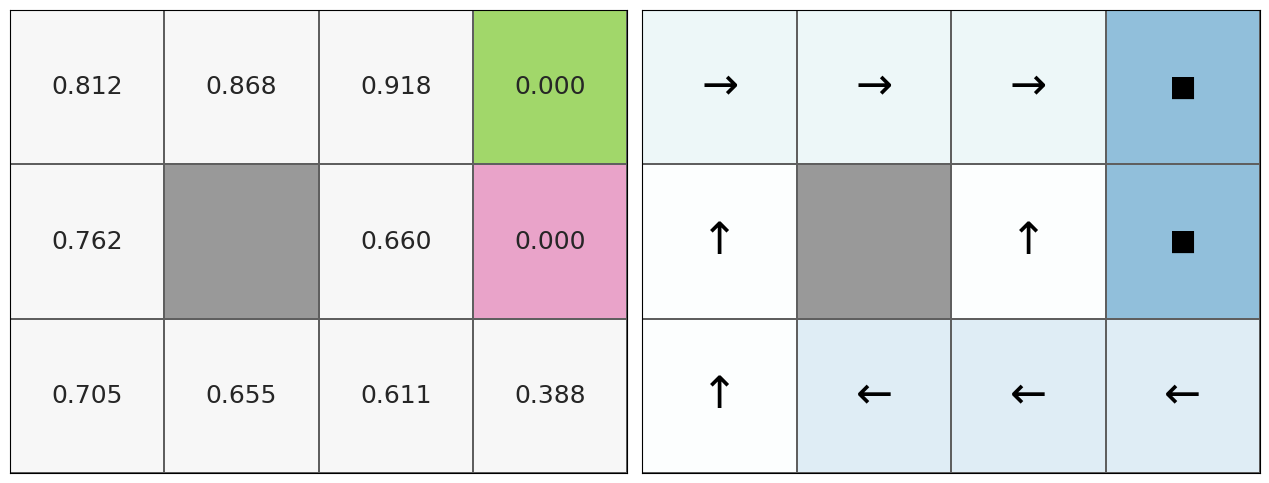

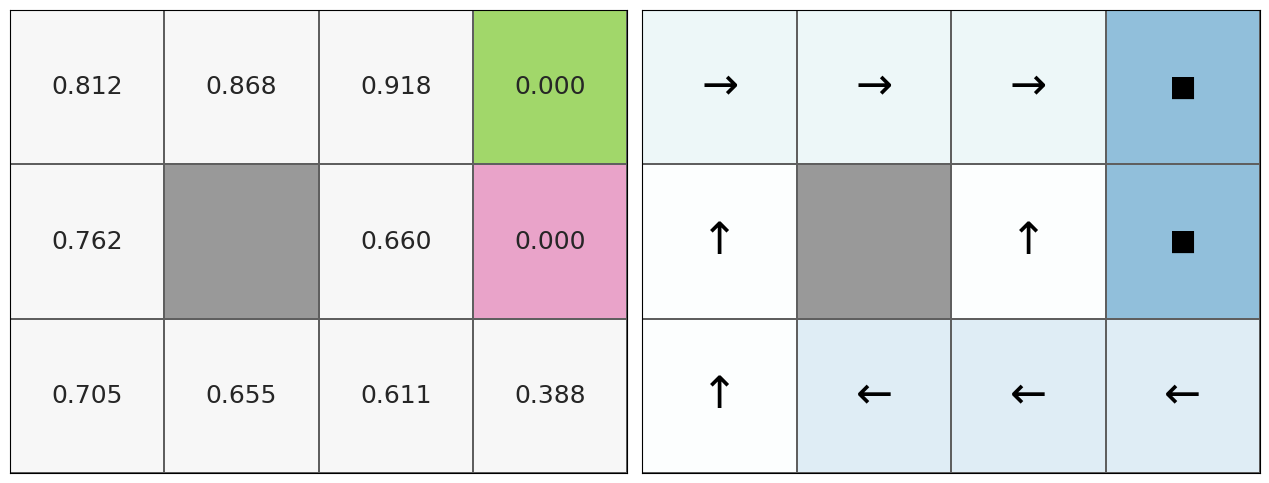

In [15]:
values = value_iteration(maze, movement, initial_values,
                         MAX_ITERS=50, C_LIMIT = 0.0001, 
                         plotter=plot_maze)
policy = extract_policy(maze, movement, values)

Now that the algorithm has converged, we can display the optimal state-values and corresponding policy for the canonical maze:

In [16]:
display(values)
display({r:Movement.action_names[policy[r]] for r in maze.get_iterator("states") if r in policy})

{(0, 0): 0.8115578603132614,
 (0, 1): 0.867808215120516,
 (0, 2): 0.9178082182507116,
 (0, 3): 0,
 (1, 0): 0.7615570300332308,
 (1, 2): 0.6602739699797393,
 (1, 3): 0,
 (2, 0): 0.7052958130511873,
 (2, 1): 0.6552719217316947,
 (2, 2): 0.6113385080325585,
 (2, 3): 0.38776334088736286}

{(0, 0): 'EAST',
 (0, 1): 'EAST',
 (0, 2): 'EAST',
 (1, 0): 'NORTH',
 (1, 2): 'NORTH',
 (2, 0): 'NORTH',
 (2, 1): 'WEST',
 (2, 2): 'WEST',
 (2, 3): 'WEST'}

## Example 2: a slightly more complicated maze

As a second example, we run through corresponding steps for a sligthly more complicated maze, again using `gamma=1`, `living_cost=-0.04` and `noise=0.2`.

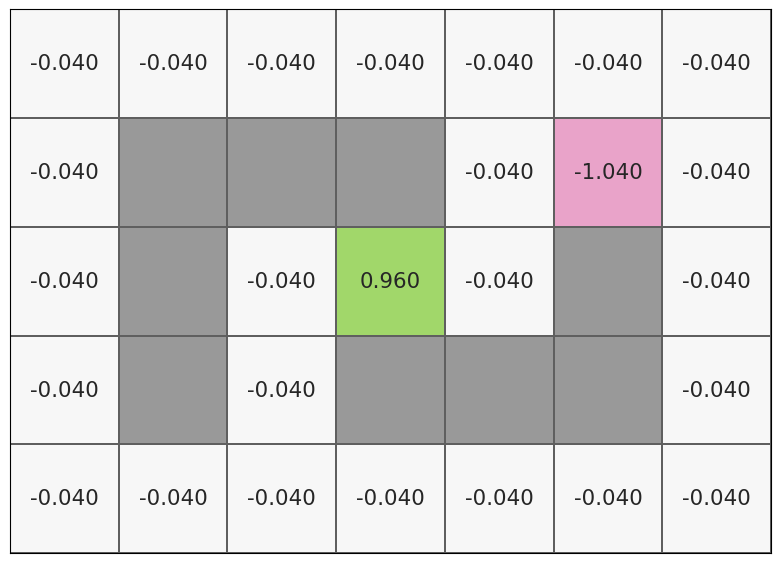

In [17]:
maze_config2 = {
    'size': (5, 7),
    'walls': [(1,1), (1,2), (1,3), (2,1), (3,1),
              (3,3), (3,4), (3,5), (2,5), (3,5) ],
    'terminal_states': [(2,3), (1,5)],
    'rewards': {
        (2,3): 1,
        (1,5): -1
    }
}
maze2 = Maze(maze_config2, gamma=1, living_cost = -0.04)
movement2 = Movement(maze2, noise=0.2)

plot_state_rewards(maze2, ax=None)

We initialize state-values to zero and run `value_iteration` for max 50 iterations or until reaching treshold of $\theta$= 0.0001.

Note that this time omit the `plotter` argument and thus skip plotting intermediate value functions or policies.


In [18]:
initial_values2 = { state:0 for state in maze2.get_iterator("states") }

values2 = value_iteration(maze2, movement2, initial_values2, 
                          MAX_ITERS=50, C_LIMIT = 0.0001)
policy2 = extract_policy(maze2, movement2, values2)

ROUND 0, 0.76
ROUND 1, 0.6
ROUND 2, 0.4719999999999999
ROUND 3, 0.3696
ROUND 4, 0.28768
ROUND 5, 0.222144
ROUND 6, 0.2064153600000002
ROUND 7, 0.17810380800000014
ROUND 8, 0.16803747840000013
ROUND 9, 0.16770193408000006
ROUND 10, 0.1331408691200001
ROUND 11, 0.13271940546560004
ROUND 12, 0.10326292512767996
ROUND 13, 0.0716963145646079
ROUND 14, 0.06208998074983668
ROUND 15, 0.04354646464237716
ROUND 16, 0.0275692659502981
ROUND 17, 0.016715627567039038
ROUND 18, 0.009847019857048611
ROUND 19, 0.006579186301665874
ROUND 20, 0.004239931488036586
ROUND 21, 0.0026094390671858037
ROUND 22, 0.0015523087102410904
ROUND 23, 0.0009012574887135028
ROUND 24, 0.0005135249983699852
ROUND 25, 0.0002882824405033291
ROUND 26, 0.00015988888136470036
ROUND 27, 8.779284895016337e-05


Now that we have the (near) optimal state-values, we can plot the values as well as the corresponding optimal policy on the maze grid:

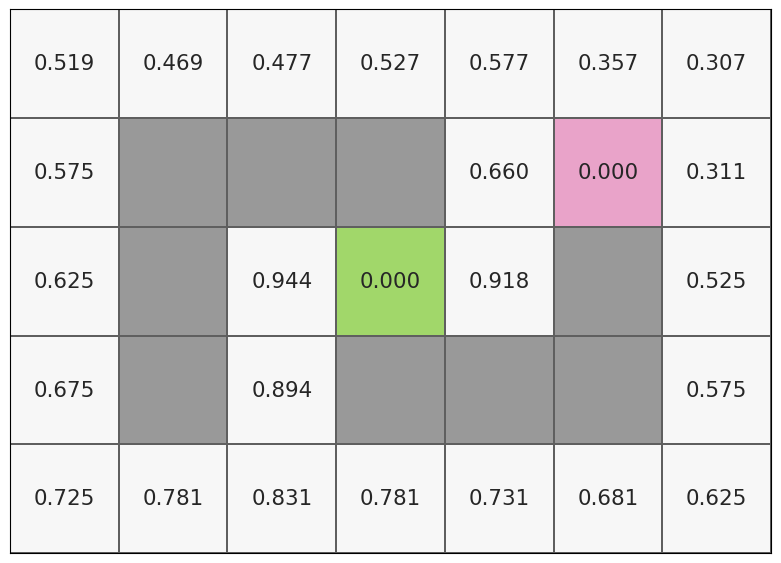

In [19]:
plot_state_values(maze2, values2)

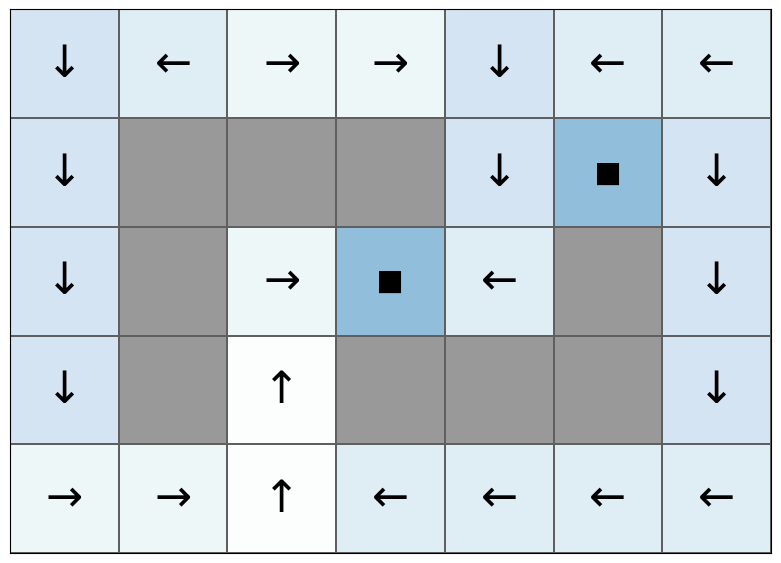

In [20]:
plot_policy_actions(maze2, policy2)

## Final example: a complex maze

As final example, we create an even more complex maze of almost mindboggling complexity, with multiple terminal states and this time apply a discount factor as well. We use the following definitions:

In [21]:
maze_config3 = {
    'size': (8, 7),
    'walls': [ (1,1), (1,2), (1,4), 
              (2,1), (2,4), 
              (4,3),(4,5), (4,6),
              (5,2),
              (6,3), (6,4), (6,5),
              (7,1) ],
    'terminal_states': [ (1,5), (2,2), (2,5), (4,1), (4,2), (5,1), (5,3) ],
    'rewards': {
        (1,5): -1,
        (2,2): -1,
        (2,5): -1,
        (4,1): -1,
        (4,2): -1,
        (5,3):  1,
        (5,1): -1,
    }
}
maze3 = Maze(maze_config3, gamma=0.9, living_cost = -0.01)
movement3 = Movement(maze3, noise=0.2)

initial_values3 = { state:0 for state in maze3.get_iterator("states") }

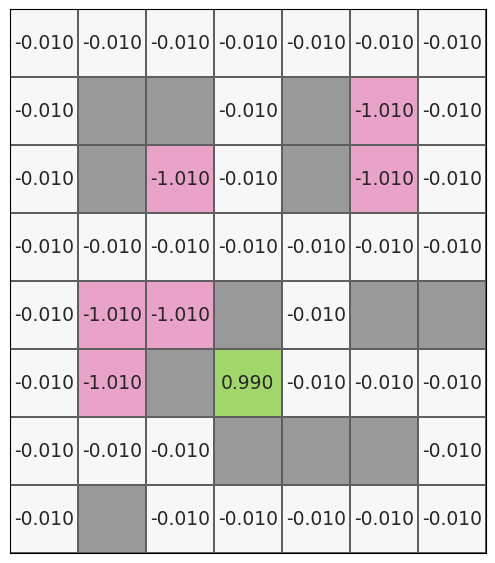

In [22]:
plot_state_rewards(maze3, ax=None)

In [23]:
values3 = value_iteration(maze3, movement3, initial_values3,
                          MAX_ITERS=1000, C_LIMIT = 0.0001)
policy3 = extract_policy(maze3, movement3, values3)

ROUND 0, 0.79
ROUND 1, 0.5670000000000001
ROUND 2, 0.4066200000000001
ROUND 3, 0.2913084
ROUND 4, 0.20974204800000001
ROUND 5, 0.14888851056000002
ROUND 6, 0.12146139324863998
ROUND 7, 0.10655683534759677
ROUND 8, 0.0903040697564444
ROUND 9, 0.07561880439350269
ROUND 10, 0.06409072327837209
ROUND 11, 0.05094261971381079
ROUND 12, 0.039564885017308135
ROUND 13, 0.027256004045936644
ROUND 14, 0.021788183796376204
ROUND 15, 0.01770904173259475
ROUND 16, 0.013943662627141688
ROUND 17, 0.01145223992685368
ROUND 18, 0.008235125707952404
ROUND 19, 0.005495870768393779
ROUND 20, 0.0034923825555251697
ROUND 21, 0.0023284157242665013
ROUND 22, 0.0020695023061098605
ROUND 23, 0.0017821249471467945
ROUND 24, 0.0015034099511129564
ROUND 25, 0.0012513839194598086
ROUND 26, 0.001032617326587694
ROUND 27, 0.0008474326228315662
ROUND 28, 0.0006931185259593728
ROUND 29, 0.0005657836169322694
ROUND 30, 0.0004613406672952375
ROUND 31, 0.00037719793853812494
ROUND 32, 0.00030976193399501195
ROUND 33, 0.000

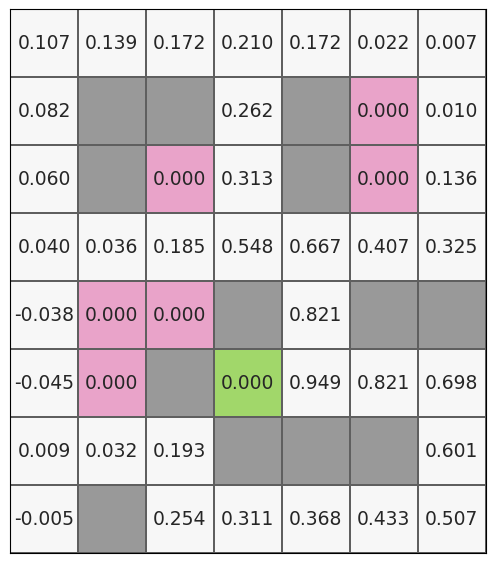

In [24]:
plot_state_values(maze3, values3)

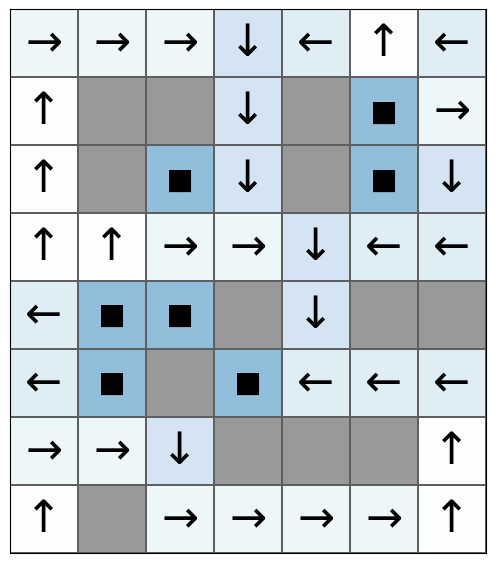

In [25]:
plot_policy_actions(maze3, policy3)

## Timing it

Finally, we time the execution of the algorithm to get an idea of the relative computational burden.

In [26]:
%%capture c
%%timeit -o 

values3 = value_iteration(maze3, movement3, initial_values3,
                          MAX_ITERS=1000, C_LIMIT = 0.0001)
policy3 = extract_policy(maze3, movement3, values3)

In [27]:
import re
regex = r'.*$'
timeitresults = re.findall(regex, c.stdout)
print(timeitresults[0])

68.9 ms +- 530 us per loop (mean +- std. dev. of 7 runs, 10 loops each)


We compare the result to policy iteration in the [end of the notebook](./maze_policy_iteration.ipynb#Timing-the-execution) 
covering policy iteration implementation.